## Домашнее задание

1. Обучите CNN (самописная) на CIFAR-100.
2. Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50.
3. *Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50 с аугментацией данных.

## Самописная CNN

In [ ]:
import numpy as np
import torch

from torch import nn
from torch.nn import functional as F
from PIL import Image
from torchvision import transforms, datasets, models
from tqdm import tqdm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

torch.manual_seed(42)

In [ ]:
dataset = datasets.CIFAR100(root='data/', train=True, download=True)


class MyOwnCifar(torch.utils.data.Dataset):
   
    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(img)
        lbl = self._base_dataset[idx][1]

        return img, lbl


def train_valid_split(Xt):
    X_train, X_test = train_test_split(Xt, test_size=0.05, random_state=13)
    return X_train, X_test

Files already downloaded and verified


In [ ]:
classes = dataset.classes

In [ ]:
trans_actions = transforms.Compose([transforms.Resize(44),
                                    transforms.RandomCrop(32, padding=4), 
                                    transforms.ToTensor()])

train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, transforms.ToTensor())

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=1)

torch.Size([128, 3, 32, 32])
mouse


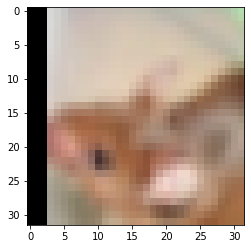

In [ ]:
for img, lbl in train_loader:
    print(img.size())
    print(classes[lbl[0]])
    plt.imshow(img[0].permute(1, 2, 0))
    break

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.dp_one = nn.Dropout(0.25)
        self.dp_two = nn.Dropout(0.15)
        
        self.bn_one = torch.nn.BatchNorm2d(3) 
        self.conv_one = torch.nn.Conv2d(3, 100, 3)
        self.bn_two = torch.nn.BatchNorm2d(100) 
        self.conv_two = torch.nn.Conv2d(100, 120, 3)
        self.bn_three = torch.nn.BatchNorm2d(120)
        self.conv_three = torch.nn.Conv2d(120, 150, 3)
        self.bn_four = torch.nn.BatchNorm2d(150)
        self.fc1 = torch.nn.Linear(600, 200)
        self.fc2 = torch.nn.Linear(200, 120)
        self.out = torch.nn.Linear(120, 100)
        
    def forward(self, x):
        x = self.bn_one(x)
        x = self.conv_one(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_two(x)
        x = self.conv_two(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_three(x)
        x = self.conv_three(x)
        x = F.leaky_relu(x, 0.1)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_four(x)
        x = x.view(x.size(0), -1)
        x = self.dp_one(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp_two(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.out(x)
       
net = Net().to(device)
print(net)

Net(
  (dp_one): Dropout(p=0.25, inplace=False)
  (dp_two): Dropout(p=0.15, inplace=False)
  (bn_one): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_one): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1))
  (bn_two): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_two): Conv2d(100, 120, kernel_size=(3, 3), stride=(1, 1))
  (bn_three): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_three): Conv2d(120, 150, kernel_size=(3, 3), stride=(1, 1))
  (bn_four): BatchNorm2d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=600, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=120, bias=True)
  (out): Linear(in_features=120, out_features=100, bias=True)
)


In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 25
net.train()

for epoch in range(num_epochs):  
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()
        
        # выводим статистику о процессе обучения
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            net.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(valid_loader):
            
                test_outputs = net(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()
            
            print(f'Test acc: {test_running_right / test_running_total:.3f}')
        
        net.train()
        
print('Training is finished!')

Epoch [1/25]. Step [1/372]. Loss: 0.036. Acc: 0.008. Test acc: 0.008
Epoch [1/25]. Step [301/372]. Loss: 0.033. Acc: 0.046. Test acc: 0.062
Epoch [2/25]. Step [1/372]. Loss: 0.033. Acc: 0.039. Test acc: 0.059
Epoch [2/25]. Step [301/372]. Loss: 0.031. Acc: 0.076. Test acc: 0.100
Epoch [3/25]. Step [1/372]. Loss: 0.031. Acc: 0.102. Test acc: 0.079
Epoch [3/25]. Step [301/372]. Loss: 0.030. Acc: 0.091. Test acc: 0.097
Epoch [4/25]. Step [1/372]. Loss: 0.030. Acc: 0.094. Test acc: 0.100
Epoch [4/25]. Step [301/372]. Loss: 0.030. Acc: 0.105. Test acc: 0.129
Epoch [5/25]. Step [1/372]. Loss: 0.030. Acc: 0.117. Test acc: 0.124
Epoch [5/25]. Step [301/372]. Loss: 0.029. Acc: 0.116. Test acc: 0.145
Epoch [6/25]. Step [1/372]. Loss: 0.029. Acc: 0.117. Test acc: 0.104
Epoch [6/25]. Step [301/372]. Loss: 0.029. Acc: 0.127. Test acc: 0.133
Epoch [7/25]. Step [1/372]. Loss: 0.029. Acc: 0.172. Test acc: 0.124
Epoch [7/25]. Step [301/372]. Loss: 0.028. Acc: 0.132. Test acc: 0.150
Epoch [8/25]. Step [

## Дообучение Resnet-50

In [ ]:
from torchvision import models

resnet50 = models.resnet50(pretrained=True)
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
from torchsummary import summary
summary(resnet50.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
for param in list(resnet50.parameters())[:]:
    param.requires_grad = False

In [ ]:
resnet50.fc = nn.Linear(2048, 100)

summary(resnet50.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

In [ ]:
resnet50 = resnet50.to(device)

In [ ]:
train_actions = transforms.Compose([transforms.Resize(256),
                                    transforms.RandomCrop(224, padding=4), 
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
valid_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])


train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, train_actions)
valid_dataset = MyOwnCifar(valid_dataset, valid_transforms)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=128,
                                           shuffle=False,
                                           num_workers=1)

In [ ]:
params_to_update = []
for name, param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)


optimizer = torch.optim.Adam(params_to_update, lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 25
resnet50.train()

for epoch in range(num_epochs):  
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()
        
        # выводим статистику о процессе обучения
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            resnet50.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(valid_loader):
            
                test_outputs = resnet50(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()
            
            print(f'Test acc: {test_running_right / test_running_total:.3f}')

        resnet50.train()
        
print('Training is finished!')

Epoch [1/25]. Step [1/372]. Loss: 0.036. Acc: 0.000. Test acc: 0.012
Epoch [1/25]. Step [301/372]. Loss: 0.020. Acc: 0.392. Test acc: 0.521
Epoch [2/25]. Step [1/372]. Loss: 0.015. Acc: 0.562. Test acc: 0.529
Epoch [2/25]. Step [301/372]. Loss: 0.013. Acc: 0.539. Test acc: 0.554
Epoch [3/25]. Step [1/372]. Loss: 0.014. Acc: 0.516. Test acc: 0.540
Epoch [3/25]. Step [301/372]. Loss: 0.013. Acc: 0.560. Test acc: 0.561
Epoch [4/25]. Step [1/372]. Loss: 0.011. Acc: 0.594. Test acc: 0.551
Epoch [4/25]. Step [301/372]. Loss: 0.012. Acc: 0.578. Test acc: 0.572
Epoch [5/25]. Step [1/372]. Loss: 0.013. Acc: 0.594. Test acc: 0.566
Epoch [5/25]. Step [301/372]. Loss: 0.011. Acc: 0.592. Test acc: 0.577
Epoch [6/25]. Step [1/372]. Loss: 0.010. Acc: 0.633. Test acc: 0.572
Epoch [6/25]. Step [301/372]. Loss: 0.011. Acc: 0.598. Test acc: 0.585
Epoch [7/25]. Step [1/372]. Loss: 0.010. Acc: 0.609. Test acc: 0.578
Epoch [7/25]. Step [301/372]. Loss: 0.011. Acc: 0.604. Test acc: 0.576
Epoch [8/25]. Step [

Предобученная сеть показывает лучшую точность, чем самописная